# Double machine learning

In [3]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict

In [4]:
import os
import requests

def download_from_url(url, filename, overwrite=False):
    if os.path.exists(filename) and not overwrite:
        return
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)


### Part I: Understanding the data: Sales in E-commerce company

We are employed by an e-commerce firm, where our objective is to determine the Average Treatment Effect (ATE) of the duration a user spends on our website on their total purchase value, or sales, over the previous month. We have measured all potential confounding variables and the DAG is defined as follows:

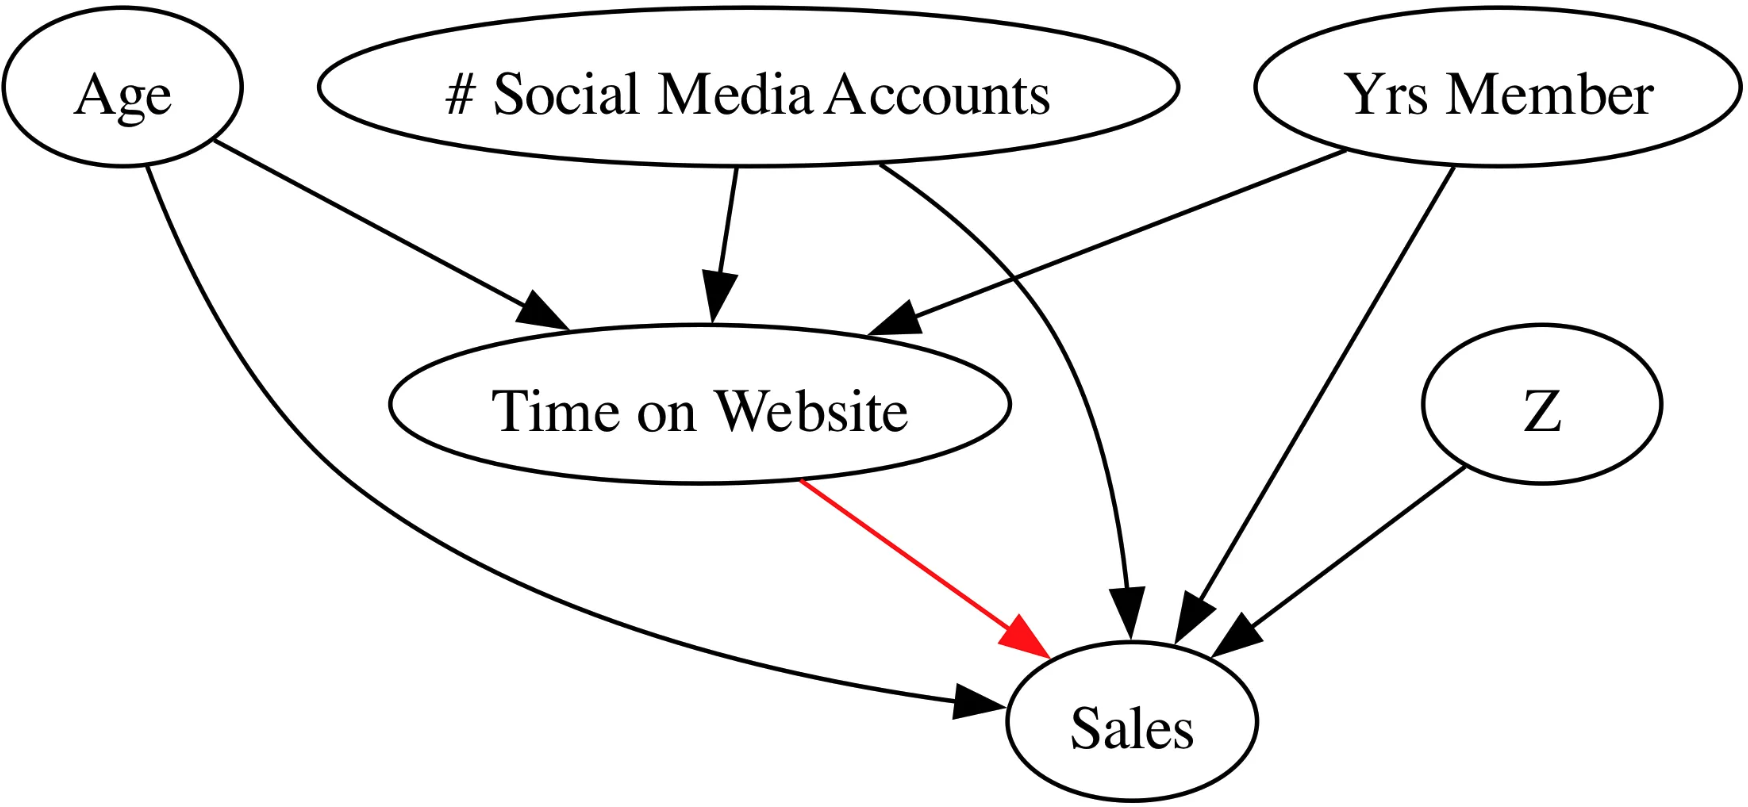

In [5]:
from IPython.display import Image
download_from_url('https://nyu.box.com/shared/static/fy6nr6twgi7hz91kcs8zeeqsbku0t10y.png', 'dgp_sales.png')
Image('dgp_sales.png')

In [6]:
# Sample Size
N = 100_000

# Observed Confounders X (Age, Number of Social Media Accounts, & Years Member on Website)
age = np.random.randint(low=18, high=75,size=N)
num_social_media_profiles = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
yr_membership = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)

# Additional Covariates (Arbitrary Z)
Z = np.random.normal(loc=50, scale = 25, size = N)

# Error Terms
ε_1 = np.random.normal(loc=20,scale=5,size=N)
ε_2 = np.random.normal(loc=40,scale=15,size=N)

# Treatment DGP (A = g(X) + ε) - Hrs spent on website in past month
time_on_website = np.maximum(10
                             - 0.01 * age
                             - 0.001 * age**2
                             + num_social_media_profiles
                             - 0.01 * num_social_media_profiles**2
                             - 0.01 * (age * num_social_media_profiles)
                             + 0.2 * yr_membership
                             + 0.001 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 0.2 * (num_social_media_profiles * yr_membership)
                             + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + ε_1
                              ,0)

# Outcome DGP (y = f(A, X, Z) + ε) - Sales in past month
sales = np.maximum(25
                   +  5 * time_on_website
                   - 0.1 * age
                   - 0.001 * age**2
                   + 8 * num_social_media_profiles
                   - 0.1 * num_social_media_profiles**2
                   - 0.01 * (age * num_social_media_profiles)
                   + 2 * yr_membership
                   + 0.1 * yr_membership**2
                   - 0.01 * (age * yr_membership)
                   + 3 * (num_social_media_profiles * yr_membership)
                   + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                   + 0.5 * Z
                   + ε_2
                     ,0)

df = pd.DataFrame(np.array([sales,time_on_website,age,num_social_media_profiles,yr_membership,Z]).T
                  ,columns=["sales","time_on_website","age","num_social_media_profiles","yr_membership","Z"])

In [7]:
df.head()

,sales,time_on_website,age,num_social_media_profiles,yr_membership,Z
0,1104.444571,78.803056,63.0,9.0,4.0,20.559002
1,1116.765722,82.821781,61.0,7.0,6.0,40.891930
2,686.427213,48.967015,54.0,5.0,5.0,48.305851
3,1516.768232,100.365010,63.0,8.0,9.0,106.652066
4,228.302924,27.362450,51.0,0.0,5.0,40.363376


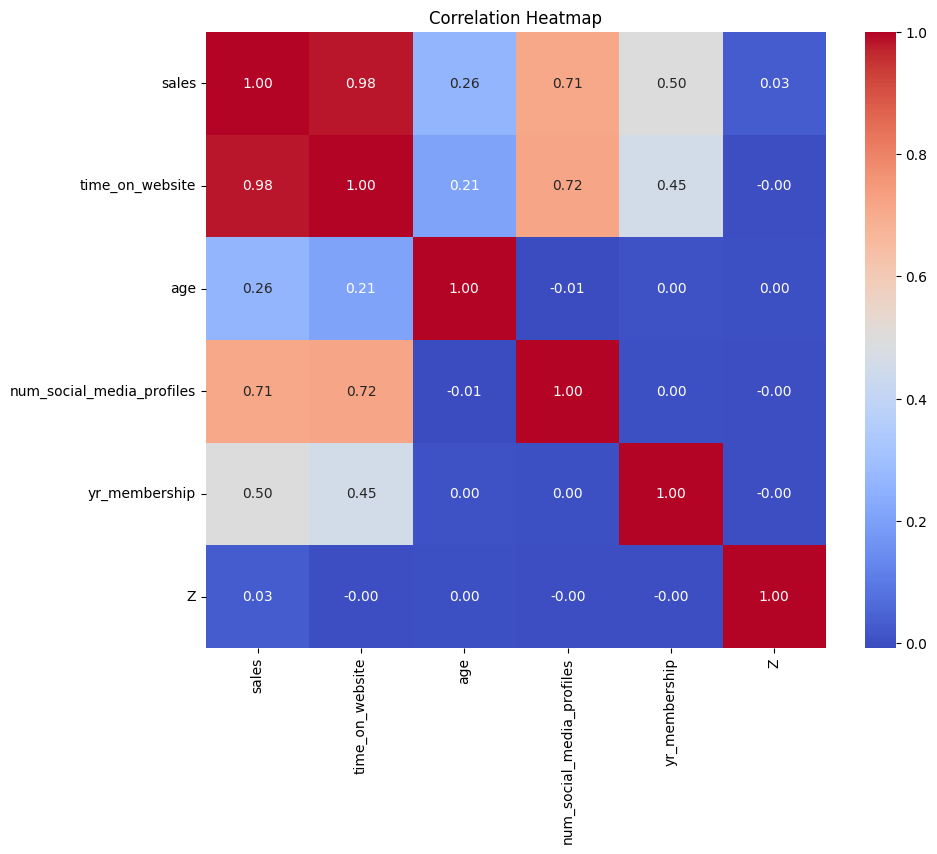

In [8]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Ground truth for the ATE is $5$ -- for every additional hour the individual spends on the website, they spend an additional $5$

### Part II: OLS model

* Naïve OLS of sales (Y) on hours spent on the website (A)
* Multiple OLS of sales (Y) on hours spent on the website (A) and linear terms of all of the confounders (X)

Marginalizing out the covariates while intervening on action vs removing all the effects of the covariates will not agree with each other. If we use a model that predicts the outcome directly,

In [9]:
def ols_naive(data, print_summary=False):
    model_ols = smf.ols(formula="sales ~ 1 + time_on_website",data=df).fit()

    if print_summary: print(model_ols.summary())

    return model_ols.params

In [10]:
def ols_multiple(data, print_summary=False):
    model_ols = smf.ols(formula="sales ~ 1 + time_on_website + age + num_social_media_profiles + yr_membership", data=data).fit()

    if print_summary: print(model_ols.summary())

    return model_ols.params

In [11]:
coef_ols_naive = ols_naive(data=df, print_summary=True)
coef_ols = ols_multiple(data=df, print_summary=True)
print(f'\n Naive model {coef_ols_naive}, \n OLS {coef_ols}')

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 2.960e+06
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        15:56:18   Log-Likelihood:            -5.6228e+05
No. Observations:              100000   AIC:                         1.125e+06
Df Residuals:                   99998   BIC:                         1.125e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -197.8899      0.532   -3

### Part II: Double Machine learning

\begin{align}
x ← \varepsilon_x \\
a ← f_a(x, \varepsilon_a) , ~~ x \perp\!\!\!\!\perp \varepsilon_a \\
y ← f_{y}(a, x, \epsilon_y) ~~ x \perp\!\!\!\!\perp \varepsilon_y
\end{align}



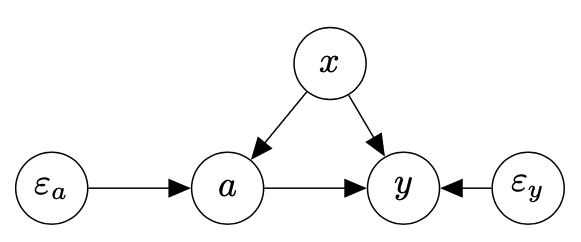

In [12]:
download_from_url('https://nyu.box.com/shared/static/mnet7ch1504aqskdcszi7wqgwxf4hawh.png', 'double_machine_learning.png')
Image('double_machine_learning.png')

**Algorithm:**
1. Regress the outcome $Y$ on $X$: ${Y}^* = \widehat{\gamma}_1X$
2. Regress the treatment $A$ on the confounders $X$ as ${A}^* = \widehat{\gamma}_2X$
3. Obtain the residuals ${A}_\perp = A - {A}^*$ and ${Y}_\perp = Y - {Y}^*$
4. Regress the residuals of the outcome on the residuals of the features ${Y}_\perp = \widehat{\beta}{A}_\perp$

In [10]:
def dml_ols(data, print_summary=False):

    # Model for treatment
    model_treatment = smf.ols("time_on_website~age+num_social_media_profiles+yr_membership", data=data).fit()

    # Model for outcome
    model_outcome = smf.ols("sales~age+num_social_media_profiles+yr_membership", data=data).fit()

    final_model = smf.ols("sales_res~time_res",
                  data=df.assign(sales_res=model_outcome.resid, # sales residuals
                                    time_res=model_treatment.resid) # time residuals
                  ).fit()

    if print_summary: print(final_model.summary())

    return final_model.params

In [11]:
params = dml_ols(data=df, print_summary=True)
print(f'Parameters: {params}')

                            OLS Regression Results                            
Dep. Variable:              sales_res   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 7.641e+05
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:32:55   Log-Likelihood:            -5.3966e+05
No. Observations:              100000   AIC:                         1.079e+06
Df Residuals:                   99998   BIC:                         1.079e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.993e-13      0.169   1.18e-12      1.0

### Part III: Double Machine learning

1. Estimate the outcome $Y$ from $X$ using $g_y(x)$.
2. Estimate the treatment $A$ with features $X$ using $g_a(x)$.
3. Obtain the residuals $Y_\perp = Y - g_y(X)$ and $A_\perp = A - g_a(X)$
4. Regress the residuals of the outcome on the residuals of the treatment ${Y}_\perp = {A}_\perp\widehat{\beta}$


In [12]:
def dml_gradient_boosting(data, print_summary=False):

    X_vars = ["age","num_social_media_profiles","yr_membership"]
    model_outcome = GradientBoostingRegressor()
    model_treatment = GradientBoostingRegressor()

    df["sales_res"] = df["sales"] - cross_val_predict(model_outcome, data[X_vars], data["sales"], cv=3)
    df["time_res"] = df["time_on_website"] - cross_val_predict(model_treatment, data[X_vars], data["time_on_website"], cv=3)

    final_model = smf.ols(formula="sales_res ~ 1 + time_res", data = data).fit()
    if print_summary: print(final_model.summary())
    return

In [13]:
coeff_dml = dml_gradient_boosting(data=df, print_summary=True)

                            OLS Regression Results                            
Dep. Variable:              sales_res   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                 1.314e+05
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:33:35   Log-Likelihood:            -4.6300e+05
No. Observations:              100000   AIC:                         9.260e+05
Df Residuals:                   99998   BIC:                         9.260e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0636      0.078     -0.811      0.4